# Попытка применить Catboost*

*попытка неудачная, ниже опишу подробнее почему

In [1]:
import pandas as pd
import polars as pl
import numpy as np
np.random.seed(2025)
import typing as t
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from tqdm.notebook import tqdm
from IPython.display import HTML
from dataclasses import dataclass
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

import multiprocessing

num_cores = multiprocessing.cpu_count()


In [2]:
data_folder = "/home/gleb_galagan/tbank_recsys/sirius_recsys/sirius-2025-recsys/data/"
train = pl.read_parquet(data_folder + "train.pq")
books = pl.read_parquet('/home/gleb_galagan/tbank_recsys/baseline_solution/books_all_embs.parquet')
# books_descr = pl.read_parquet('/home/gleb_galagan/tbank_recsys/baseline_solution/books_title_description_emb.parquet')
test_exploded = pl.read_parquet(data_folder + "test.pq")
test = test_exploded.group_by("user_id", maintain_order=True).agg(pl.col("item_id"))

In [3]:

import pandas as pd
import polars as pl
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection
from sklearn.preprocessing import StandardScaler
import time

def extract_embeddings_to_array(df, embedding_col):
    """Extract embeddings from polars DataFrame to numpy array"""
    embeddings = []
    for row in df.iter_rows():
        embed = row[df.columns.index(embedding_col)]
        if embed is not None and len(embed) > 0:
            embeddings.append(np.array(embed, dtype=np.float32))
        else:
            # Handle missing embeddings with zeros
            embeddings.append(np.zeros(1024, dtype=np.float32))  # Assuming 1024 is original dim
    return np.vstack(embeddings)


def reduce_embeddings_pca(books_df, embedding_columns, n_components=64):
    """
    Уменьшаем размер эмбеддингов с помощью PCA
    """
    print(f"Reducing embeddings to {n_components} dimensions using PCA...")
    
    books_reduced = books_df.clone()
    
    for col in embedding_columns:
        print(f"Processing {col}...")
        start_time = time.time()
        
        # Extract embeddings to numpy array
        embeddings = extract_embeddings_to_array(books_df, col)
        
        # Standardize before PCA (recommended)
        scaler = StandardScaler()
        embeddings_scaled = scaler.fit_transform(embeddings)
        
        # Apply PCA
        pca = PCA(n_components=n_components, random_state=42)
        embeddings_reduced = pca.fit_transform(embeddings_scaled)
        
        # Convert back to list format for polars
        embeddings_list = [emb.tolist() for emb in embeddings_reduced]
        
        # Replace in dataframe
        new_col_name = f"{col}_pca_{n_components}"
        books_reduced = books_reduced.with_columns(
            pl.Series(embeddings_list).alias(new_col_name)
        ).drop(col)
        
        print(f"  {col} -> {new_col_name}: {time.time() - start_time:.2f}s")
        print(f"  Explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")
    
    return books_reduced

In [4]:
embedding_columns = ['image_embedding', 'description_embeddings']

books = reduce_embeddings_pca(books.clone(), embedding_columns, n_components=64)

Reducing embeddings to 64 dimensions using PCA...
Processing image_embedding...
  image_embedding -> image_embedding_pca_64: 8.10s
  Explained variance ratio: 0.576
Processing description_embeddings...
  description_embeddings -> description_embeddings_pca_64: 7.83s
  Explained variance ratio: 0.451


## 1. Сплитим данные на train и val

In [5]:
import polars as pl
from datetime import timedelta

# Extract the scalar value from the DataFrame
last_date = train.select(pl.col('date_added')).max().item()
threshold = last_date - timedelta(days=40)

train = train.with_columns(
    pl.col('is_read').cast(pl.Int8).alias('is_read')
)
train_set = train.filter(pl.col('date_added') <= threshold)
val_set = train.filter(pl.col('date_added') > threshold)
print(train_set.shape, val_set.shape)

(11500496, 5) (470941, 5)


In [6]:
train_books = set(train_set['item_id'].unique())

# Делим айтемы без даталиков, только те что есть в val_set
books_train_only = books.filter(pl.col('item_id').is_in(train_books))

train_set = train_set.join(
    books_train_only.select(['item_id', 'embedding_tags', 'description_embeddings_pca_64', 'image_embedding_pca_64']), 
    on='item_id', 
    how="left"
)

val_set = val_set.join(
    books_train_only.select(['item_id', 'embedding_tags', 'description_embeddings_pca_64', 'image_embedding_pca_64']), 
    on='item_id', 
    how="left"
)

**Ключевой момент** вот мы здесь понимаем что у нас нет чисто фичей юзера и нам нужно джоинить интеракции юзеров с айтемами. **Но как же быть с более чем 3к книг без интеракций**

Отсюда следуюет то что мы не сможем решить проблему холодного старта с имеющимися фичами и катбустом. Если бы еще у юзеров были свои фичи. 

**Future work**: можно попробовать подать описание(фича decription) прочитанных книг их названия, теги, LLMке чтобы она составила примерный портрет юзера, полученные текстовые описания можно векторизовать текстовым энкодером *(можно попробовать но время движется к дедлайну)*

### Приводим к типу данных для Catboost

In [7]:
from catboost import CatBoostRanker, Pool
from copy import deepcopy
train_set = train_set.to_pandas()
val_set = val_set.to_pandas()

feature_columns = ['is_read','embedding_tags', 'description_embeddings_pca_64', 'image_embedding_pca_64']

# data_train = train_set.drop('rating', axis=1)
train_set = train_set.sort_values('user_id')
val_set = val_set.sort_values('user_id')

data_train = train_set[feature_columns]
label_train = train_set['rating']

group_train = train_set['user_id'].values

# data_val = val_set.drop('rating', axis=1)
data_val = val_set[feature_columns]  # Exclude user_id from features
label_val = val_set['rating']
group_val = val_set['user_id'].values


train_pool = Pool(
    data=data_train,
    label=label_train,
    group_id=group_train,
    embedding_features=['embedding_tags', 'description_embeddings_pca_64', 'image_embedding_pca_64']
)


embedding_dim_tags = len(data_val["embedding_tags"].iloc[0])
embedding_dim_images = len(data_val["image_embedding_pca_64"].iloc[0])
embedding_dim_description = len(data_val["description_embeddings_pca_64"].iloc[0])

def fix_embedding(x, embedding_dim):
    if isinstance(x, (list, np.ndarray)):
        arr = np.array(x, dtype=np.float32)
        if arr.shape[0] != embedding_dim:
            print('Err')
            return np.zeros(embedding_dim, dtype=np.float32)
        return arr
    else:
        return np.zeros(embedding_dim, dtype=np.float32)

data_val["embedding_tags"] = data_val["embedding_tags"].apply(
    fix_embedding, args=(embedding_dim_tags,)
)
data_val["image_embedding_pca_64"] = data_val["image_embedding_pca_64"].apply(
    fix_embedding, args=(embedding_dim_images,)
)
data_val["description_embeddings_pca_64"] = data_val["description_embeddings_pca_64"].apply(
    fix_embedding, args=(embedding_dim_description,)
)

val_pool = Pool(
    data=data_val,
    label=label_val,
    group_id=group_val,
    embedding_features=['embedding_tags', 'description_embeddings_pca_64', 'image_embedding_pca_64']
)

/tmp/ipykernel_3494/1553803656.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val["embedding_tags"] = data_val["embedding_tags"].apply(
/tmp/ipykernel_3494/1553803656.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val["image_embedding_pca_64"] = data_val["image_embedding_pca_64"].apply(
/tmp/ipykernel_3494/1553803656.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

## Обучаем модель

In [8]:
default_parameters = {
    'iterations': 100,
    'custom_metric': ['NDCG', 'PFound', 'AverageGain:top=10'],
    'verbose': True,
    'random_seed': 42,
    'learning_rate': 0.1,
    'depth': 4,
    'early_stopping_rounds': 30, 
    'thread_count': num_cores
}

parameters = {}

In [9]:

def fit_model(loss_function, additional_params=None, train_pool=train_pool, val_pool=val_pool):
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function
    parameters['train_dir'] = loss_function

    if additional_params is not None:
        parameters.update(additional_params)

    model = CatBoostRanker(**parameters)
    model.fit(train_pool, eval_set=val_pool, plot=True)

    return model

In [10]:
model_rmse = fit_model('RMSE', {'custom_metric': ['PrecisionAt:top=10', 'RecallAt:top=10', 'MAP:top=10']})


/home/gleb_galagan/tbank_recsys/base_venv/lib/python3.10/site-packages/catboost/core.py:6402: RuntimeWarning: Regression loss ('RMSE') ignores an important ranking parameter 'group_id'
  warnings.warn("Regression loss ('{}') ignores an important ranking parameter 'group_id'".format(loss_function), RuntimeWarning)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.8430575	test: 1.7519415	best: 1.7519415 (0)	total: 383ms	remaining: 37.9s
1:	learn: 1.7039920	test: 1.6189410	best: 1.6189410 (1)	total: 688ms	remaining: 33.7s
2:	learn: 1.5823805	test: 1.5031939	best: 1.5031939 (2)	total: 967ms	remaining: 31.3s
3:	learn: 1.4765162	test: 1.4028184	best: 1.4028184 (3)	total: 1.25s	remaining: 30.1s
4:	learn: 1.3848588	test: 1.3160353	best: 1.3160353 (4)	total: 1.53s	remaining: 29.1s
5:	learn: 1.3057752	test: 1.2414650	best: 1.2414650 (5)	total: 1.81s	remaining: 28.3s
6:	learn: 1.2380161	test: 1.1780271	best: 1.1780271 (6)	total: 2.08s	remaining: 27.6s
7:	learn: 1.1802689	test: 1.1242500	best: 1.1242500 (7)	total: 2.34s	remaining: 26.9s
8:	learn: 1.1313759	test: 1.0790254	best: 1.0790254 (8)	total: 2.62s	remaining: 26.5s
9:	learn: 1.0900792	test: 1.0410588	best: 1.0410588 (9)	total: 2.91s	remaining: 26.2s
10:	learn: 1.0554391	test: 1.0094616	best: 1.0094616 (10)	total: 3.19s	remaining: 25.8s
11:	learn: 1.0264660	test: 0.9833155	best: 0.9833155

## 2. Сохраняем модель

In [11]:
import os
def save_catboost_model(model, filepath: str):
    """Save a CatBoost model to file."""
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    model.save_model(filepath)
    print(f"Model saved to {filepath}")

def load_catboost_model(filepath: str) -> CatBoostRanker:
    """Load a CatBoost model from file."""
    model = CatBoostRanker()
    model.load_model(filepath)
    print(f"Model loaded from {filepath}")
    return model

In [12]:
save_catboost_model(model_rmse, "models/catboost_ranker_rmse.cbm")

Model saved to models/catboost_ranker_rmse.cbm


In [13]:
loaded_model = load_catboost_model("models/catboost_ranker_rmse.cbm")


Model loaded from models/catboost_ranker_rmse.cbm


/tmp/ipykernel_3494/1615530223.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, data_train)


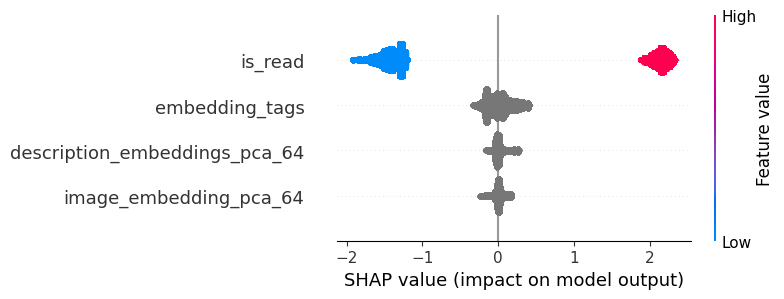

In [14]:
import shap

explainer = shap.Explainer(loaded_model)

shap_values = explainer.shap_values(train_pool)
shap.summary_plot(shap_values, data_train)


Видим то что основной фичей здесь выступает is_read, а наши эмбеддинги эмбеддинги сильно менее важные (несмотря на то что одно: легкая бинарная фича, а другие это тяжелые эмбединги)

Т.е. несмотря на то что мы подали фичи эмбеддингов корректно (в embedding_features) но все равно их importance низкий

## 3. Тестируем модель на тестовой выборке
Для экономии компьюта и времени берем сэмпл из 100 user_id но при этом берем все книги. Считаем скор для каждой пары юзер-айтем

Также мы добавляем implicit фичу is_read, чтобы по чисто контентным фичам Catboost не выдал всем одинаковый список (получается как Popular но дороже, так как оценен Catboost)

In [15]:
import pandas as pd
import numpy as np
from catboost import Pool
import polars as pl


# Берем все интеракции трейн + вал  и все фичи с которыми есть интеракции
full_items = train.join(
    books.select(['item_id', 'embedding_tags', 'description_embeddings_pca_64', 'image_embedding_pca_64']), 
    on='item_id', 
    how="left"
)
# Дропаем таргет и временную фичу
full_items = full_items.drop(['rating', 'date_added'])

user_ids = test.drop('item_id')['user_id'].unique()

items_features = books.select(['item_id', 'embedding_tags', 'description_embeddings_pca_64', 'image_embedding_pca_64'])

# Helper to fix embeddings
def fix_embedding(x, dim):
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return np.zeros(dim, dtype=np.float32)
    try:
        arr = np.array(x, dtype=np.float32)
        if arr.ndim == 0:  # scalar, not array
            return np.zeros(dim, dtype=np.float32)
        if arr.shape[0] != dim:
            return np.zeros(dim, dtype=np.float32)
        return arr
    except Exception:
        return np.zeros(dim, dtype=np.float32)

# Get dimensions from a sample
sample_item = items_features.to_pandas().iloc[0]
dim_tags = len(sample_item["embedding_tags"])
dim_desc = len(sample_item["description_embeddings_pca_64"])
dim_img = len(sample_item["image_embedding_pca_64"])

topk = 50
results = []

for idx, uid in enumerate(np.array(user_ids)[:100]):
    # Берем все взаимодействия юзера
    user_history = full_items.filter(pl.col('user_id') == uid)
    
    # Берем все уникальные айтемы
    all_items = full_items['item_id'].unique()
    
    # строим комбинацию юзер - айтем
    user_items_df = pl.DataFrame({
        'item_id': all_items,
        'user_id': [uid] * len(all_items)
    })
    
    # 4. Merge with user's reading history to get is_read values
    
    user_items_df = user_items_df.join(
        user_history.select(['item_id', 'is_read']),
        on='item_id',
        how='left'
    ).with_columns(
        pl.col('is_read').fill_null(False)  # Items not in history are unread
    )
    
    # 5. Merge with item features
    user_items_df = user_items_df.join(
        items_features,
        on='item_id',
        how='left'
    )
    
    user_items = user_items_df.to_pandas()
    
    # 7. Fix embeddings
    user_items["embedding_tags"] = user_items["embedding_tags"].apply(fix_embedding, args=(dim_tags,))
    user_items["description_embeddings_pca_64"] = user_items["description_embeddings_pca_64"].apply(fix_embedding, args=(dim_desc,))
    user_items["image_embedding_pca_64"] = user_items["image_embedding_pca_64"].apply(fix_embedding, args=(dim_img,))
    
    # print(f"User {uid} - Items read: {user_items['is_read'].sum()}, Total items: {len(user_items)}")
    
    pool = Pool(
        data=user_items[feature_columns],
        group_id=user_items["user_id"].values,
        embedding_features=[
            "embedding_tags",
            "description_embeddings_pca_64",
            "image_embedding_pca_64"
        ]
    )
    
    preds = loaded_model.predict(pool)
    user_items["score"] = preds
    
    # 11. Keep only top-K
    top_items = (
        user_items.nlargest(topk, "score")[["user_id", "item_id", "score"]]
    )
    results.append(top_items)
    
    # Progress indicator
    if idx % 10 == 0:  # More frequent for debugging
        print(f"Processed {idx} users")

# Final recommendations
recommendations = pd.concat(results, ignore_index=True)

Processed 0 users
Processed 10 users
Processed 20 users
Processed 30 users
Processed 40 users
Processed 50 users
Processed 60 users
Processed 70 users
Processed 80 users
Processed 90 users


## 4. Считаем метрики

In [16]:
n_books = books.shape[0]
print(f"N books: {n_books}")

n_cold_books = n_books - train["item_id"].n_unique()
print(f"N 'cold' books: {n_cold_books}")



N books: 34322
N 'cold' books: 3022


In [17]:
# ACHTUNG! DO NOT TOUCH

@dataclass
class AtKMetric(ABC):
    k: int

    @property
    @abstractmethod
    def name(self) -> str:
        raise NotImplementedError

    @property
    def full_name(self) -> str:
        return f"{self.name}@{self.k}"

    @abstractmethod
    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", **kwargs) -> pl.Expr:
        raise NotImplementedError


class NDCG(AtKMetric):
    @property
    def name(self) -> str:
        return "ndcg"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", **kwargs) -> pl.Expr:
        def _dcg(scores: np.ndarray) -> float:
            # Handle empty arrays
            if len(scores) == 0:
                return 0.0
            # Use vectorized operations for better performance
            positions = np.arange(1, len(scores) + 1, dtype=np.float64)
            return np.sum((np.power(2, scores) - 1) / np.log2(positions + 1))

        def ndcg(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty predictions or ground truth
            if not predicted or not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Create relevance scores (1 for relevant items, 0 otherwise)
            relevance = np.array([1 if x in gt_items else 0 for x in predicted], dtype=np.float64)
            
            rank_dcg = _dcg(relevance)
            if rank_dcg == 0.0:
                return 0.0
                
            # Ideal DCG: sort ground truth by relevance (all 1s) and take top-k
            ideal_relevance = np.ones(min(len(gt_items), self.k), dtype=np.float64)
            ideal_dcg = _dcg(ideal_relevance)
            
            if ideal_dcg == 0.0:
                return 0.0
                
            return rank_dcg / ideal_dcg

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: ndcg(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)


class Recall(AtKMetric):
    @property
    def name(self) -> str:
        return "recall"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", **kwargs) -> pl.Expr:
        def recall(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty ground truth
            if not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Calculate intersection
            intersection = len(set(gt_items).intersection(set(predicted)))
            return intersection / len(gt_items)

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: recall(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)

# ==================
# Новая метрика ARP
# ==================
class ARP(AtKMetric):
    """
    Calculates the Average Recommendation Popularity (ARP).
    This metric measures the average popularity of the recommended items.
    A lower ARP suggests the model is recommending less obvious, "long-tail" items.
    """
    @property
    def name(self) -> str:
        return "arp"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", item_popularity_map: dict[t.Any, float] | None = None, **kwargs) -> pl.Expr:
        if item_popularity_map is None:
            raise ValueError("item_popularity_map is required for ARP metric")

        def arp(predicted: list[t.Any]) -> float:
            if isinstance(predicted, pl.Series):
                predicted = predicted.to_list()
            if not predicted:
                return 0.0
            
            predicted = predicted[:self.k]
            
            # Get popularities, default to 0 if item not in map
            popularities = [item_popularity_map.get(item, 0.0) for item in predicted]
            
            if not popularities:
                return 0.0
                
            return sum(popularities) / len(popularities)

        # Note: ground_truth_col is not used but is part of the abstract method signature.
        return pl.col(preds_col).map_elements(
            lambda p: arp(p),
            return_dtype=pl.Float64
        ).alias(self.full_name)
# ==============
# Новая метрика Serndipity
# ==============
class Serendipity(AtKMetric):
    """
    Calculates Serendipity.
    This metric rewards recommendations that are both relevant (in ground truth)
    and surprising (unpopular). The score for a user is the sum of (1 - popularity)
    for each correctly recommended item.
    """
    @property
    def name(self) -> str:
        return "serendipity"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", item_popularity_map: dict[t.Any, float] | None = None, **kwargs) -> pl.Expr:
        if item_popularity_map is None:
            raise ValueError("item_popularity_map is required for Serendipity metric")

        def serendipity(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            if not predicted or not gt_items:
                return 0.0
                
            predicted = predicted[:self.k]
            
            # Find relevant recommended items
            relevant_preds = set(predicted).intersection(set(gt_items))
            
            if not relevant_preds:
                return 0.0
                
            # Score is the sum of (1 - popularity) for each relevant item
            score = sum(1 - item_popularity_map.get(item, 0.0) for item in relevant_preds)
            
            # Normalize by k to get an average serendipity score per recommendation slot
            return score / self.k

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: serendipity(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)



def coverage(df: pl.DataFrame, n_items_in_catalog: int, preds_col: str = "preds") -> float:
    if n_items_in_catalog <= 0:
        return 0.0
        
    unique_recommended = df.select(
        pl.col(preds_col).explode().n_unique()
    ).item()
    return unique_recommended / n_items_in_catalog



def evaluate_extended(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    n_items_in_catalog: int = n_books,
    k: int = 10,
    train_df: pl.DataFrame | None = None,
) -> dict:
    """
    Расширенная функция расчета метрик. Здесь добавлены ARP и Serendipity. Для расчета этих метрик считаем матрицу популярности. 
    """
    # Compute item_popularity_map from train_df
    item_popularity_map = None
    if train_df is not None:
        total_interactions = train_df.height
        if total_interactions > 0:
            item_popularity_map = dict(
                train_df
                .group_by("item_id")
                .agg(pl.count().alias("count"))
                .with_columns((pl.col("count") / total_interactions).alias("popularity"))
                .select(["item_id", "popularity"])
                .iter_rows()
            )
    

    metrics = [
        NDCG(k=k),
        Recall(k=k),
    ]

    # Add popularity-based metrics if the map is available
    if item_popularity_map:
        metrics.extend([
            ARP(k=k),
            Serendipity(k=k),
        ])

    result = {}
    result_df = df.clone()


    for metric in metrics:
        # NEW: Prepare kwargs for the metric, including popularity map if needed
        metric_kwargs = {
            "preds_col": model_preds_col,
            "ground_truth_col": ground_truth_col,
        }
        if isinstance(metric, (ARP, Serendipity)):
            if not item_popularity_map:
                # This check is for safety, but the logic should prevent this
                continue
            metric_kwargs["item_popularity_map"] = item_popularity_map

        # NEW: Calculate the metric using the prepared kwargs
        result_df = result_df.with_columns(
            metric(**metric_kwargs)
        )
        result[f"{metric.full_name}"] = round(
            result_df.select(pl.col(metric.full_name).mean()).item(), 3
        )

    if n_items_in_catalog is not None:
        result[f"coverage"] = round(
            coverage(result_df, n_items_in_catalog, preds_col=model_preds_col), 3
        )

    return result


In [18]:
def evaluate_extended_with_cold_split(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    cold_items: set[int] | None = None,
    n_items_in_catalog: int | None = None,
    k: int = 10,
    train_df: pl.DataFrame | None = train, # NEW: Added train_df to calculate popularity
) -> dict:
    """
    Calculates metrics splitting users by whether they have "cold" items in their ground truth.
    Also calculates ARP and Serendipity if train_df is provided.
    """
    # NEW: Calculate item_popularity_map from train_df for ARP and Serendipity
    item_popularity_map = None
    if train_df is not None:
        total_interactions = train_df.height
        if total_interactions > 0:
            item_popularity_map = dict(
                train_df
                .group_by("item_id")
                .agg(pl.count().alias("count"))
                .with_columns((pl.col("count") / total_interactions).alias("popularity"))
                .select(["item_id", "popularity"])
                .iter_rows()
            )

    # NEW: Conditionally add ARP and Serendipity to the metrics list
    metrics = [NDCG(k=k), Recall(k=k)]
    if item_popularity_map:
        metrics.extend([
            ARP(k=k),
            Serendipity(k=k),
        ])

    result = {}

    if not cold_items:
        # Handle case where cold_items is not provided to avoid errors
        print("Warning: `cold_items` set is not provided. Cannot perform cold/warm split.")
        return result

    # Mark rows that have cold items in their ground_truth
    df = df.with_columns(
        pl.col(ground_truth_col)
        .list.eval(pl.element().is_in(cold_items))
        .list.any()
        .alias("has_cold")
    )

    # Calculate metrics for each split
    for split_name, mask in [("cold", pl.col("has_cold")),
                             ("warm", ~pl.col("has_cold"))]:
        split_df = df.filter(mask)
        if split_df.height == 0:
            print(f"No data for '{split_name}' split, skipping.")
            continue

        for metric in metrics:
            # NEW: Prepare kwargs for the metric, including popularity map if needed
            metric_kwargs = {
                "preds_col": model_preds_col,
                "ground_truth_col": ground_truth_col,
            }
            if isinstance(metric, (ARP, Serendipity)):
                if not item_popularity_map:
                    # This check is for safety, but the logic should prevent this
                    continue
                metric_kwargs["item_popularity_map"] = item_popularity_map

            # NEW: Calculate the metric using the prepared kwargs
            split_df = split_df.with_columns(
                metric(**metric_kwargs)
            )
            result[f"{metric.full_name}_{split_name}"] = round(
                split_df.select(pl.col(metric.full_name).mean()).item(), 3
            )

        if n_items_in_catalog is not None:
            result[f"coverage_{split_name}"] = round(
                coverage(split_df, n_items_in_catalog, preds_col=model_preds_col), 3
            )

    return result

In [19]:
def get_top10_recommendations(df):
    """
    Generate top-10 item recommendations for each user based on model predictions
    """
    # Sort by user_id and score (descending)
    df_sorted = df.sort_values(['user_id', 'score'], ascending=[True, False])
    
    # Get top-10 items for each user
    top10_recs = (df_sorted
                  .groupby('user_id')['item_id']
                  .apply(lambda x: list(x.head(10)))
                  .reset_index())
    
    top10_recs.columns = ['user_id', 'preds']  # Rename for consistency
    return top10_recs

top10_recommendations = get_top10_recommendations(recommendations)
print(top10_recommendations)

                             user_id  \
0   006fee16ba67f6a08f1a7b78f84dee2e   
1   028c08543b8d3deb59d05b33c94a54ce   
2   0328aed34bf54aee01331ad2437934b3   
3   03c022566b73b481009070227f2073e2   
4   03c4ad6577b51527500638d8e342ba1f   
..                               ...   
95  f91880a2b0fc36beb38916f3b6ef9269   
96  f971dcb0e8a17afc1f15040b3a6d7db9   
97  fc3090397528d984214cacd293ef55b7   
98  fdacc154118f88267b3b7bed7aa51080   
99  ff4c237703a45c1ada0e2a61fe319d3c   

                                                preds  
0   [8718, 28354, 19110, 7052, 17447, 16874, 12453...  
1   [28354, 19110, 7052, 17447, 16874, 12453, 1186...  
2   [15514, 4058, 18150, 960, 3625, 33370, 28386, ...  
3   [15514, 4058, 31822, 12489, 3021, 32759, 33370...  
4   [27745, 28354, 19110, 7052, 17447, 16874, 1245...  
..                                                ...  
95  [13695, 17936, 28589, 19087, 118, 8039, 3513, ...  
96  [817, 13758, 1003, 24546, 19466, 2889, 960, 11...  
97  [18150, 305

In [ ]:
filtered_df = test.filter(pl.col("user_id").is_in(np.array(user_ids[:100])))

test_recommendations = pl.from_pandas(top10_recommendations)
test_res = (
            filtered_df.lazy()
            .join(test_recommendations.lazy().select(['user_id','preds']), on='user_id', how="left")
            .collect()
        )


catboost_ov = evaluate_extended(df=test_res, model_preds_col="preds", train)

catboost_ov

{'ndcg@10': 0.0, 'recall@10': 0.0, 'coverage': 0.01}

In [23]:
test_res

user_id,item_id,preds
str,list[i64],list[i64]
"""006fee16ba67f6a08f1a7b78f84dee…","[11521, 11997, … 30197]","[8718, 28354, … 32638]"
"""028c08543b8d3deb59d05b33c94a54…","[1034, 16060]","[28354, 19110, … 7524]"
"""0328aed34bf54aee01331ad2437934…",[13159],"[15514, 4058, … 19110]"
"""03c022566b73b481009070227f2073…","[241, 2870, … 34048]","[15514, 4058, … 28354]"
"""03c4ad6577b51527500638d8e342ba…",[29894],"[27745, 28354, … 32638]"
…,…,…
"""f91880a2b0fc36beb38916f3b6ef92…",[26409],"[13695, 17936, … 33370]"
"""f971dcb0e8a17afc1f15040b3a6d7d…","[2347, 5414, … 34295]","[817, 13758, … 3625]"
"""fc3090397528d984214cacd293ef55…",[7188],"[18150, 3051, … 7052]"


In [ ]:
catboost_split = evaluate_extended_with_cold_split(df=test_res, model_preds_col="preds", train)
catboost_split

/tmp/ipykernel_3494/1856606031.py:22: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))


{}

Как видно холодных айтемов у нас нет, поэтому словарь пустой

In [25]:
catboost_res_ov = {}
catboost_res_split = {}
catboost_res_ov['catboost_res'] = catboost_ov
catboost_res_split['catboost_res'] = catboost_split


In [28]:
catboost_res_ov_pd = pd.DataFrame(catboost_res_ov)
catboost_res_split_pd = pd.DataFrame(catboost_res_split)
catboost_res_ov_pd.to_csv('results_csv/catboost_res_ov.csv')
catboost_res_split_pd.to_csv('results_csv/catboost_res_split.csv')

In [29]:
catboost_res_ov_pd

,catboost_res
ndcg@10,0.00
recall@10,0.00
coverage,0.01


In [30]:
catboost_res_split_pd

,catboost_res


## EDA предсказаний и оценка 

/tmp/ipykernel_3494/2074740513.py:7: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))


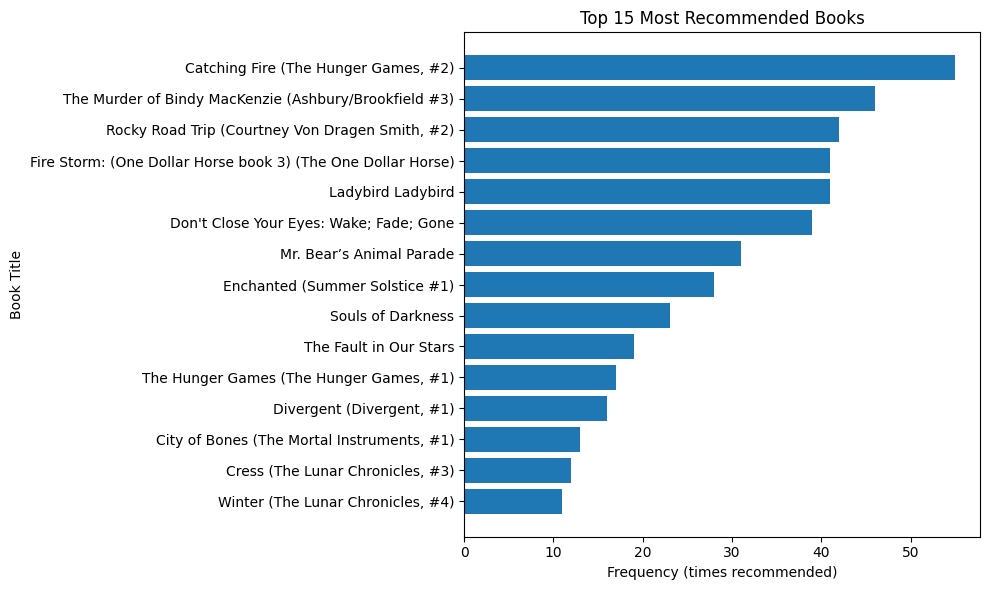

In [31]:
# 1. Flatten recommendations properly
flat_recs = test_res.select(pl.col("preds").explode().alias("item_id"))

# 2. Count frequencies
freq_df = (
    flat_recs.group_by("item_id")
    .agg(pl.count().alias("count"))
    .sort("count", descending=True)
)

# 3. Join with book titles
top_10_df = (
    freq_df.head(15)
    .join(books.select(["item_id", "title"]), on="item_id", how="left")
)

# 4. Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(top_10_df["title"].to_list()[::-1], top_10_df["count"].to_list()[::-1])
plt.xlabel("Frequency (times recommended)")
plt.ylabel("Book Title")
plt.title("Top 15 Most Recommended Books")
plt.tight_layout()
plt.show()


/tmp/ipykernel_3494/1044461507.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("count"))


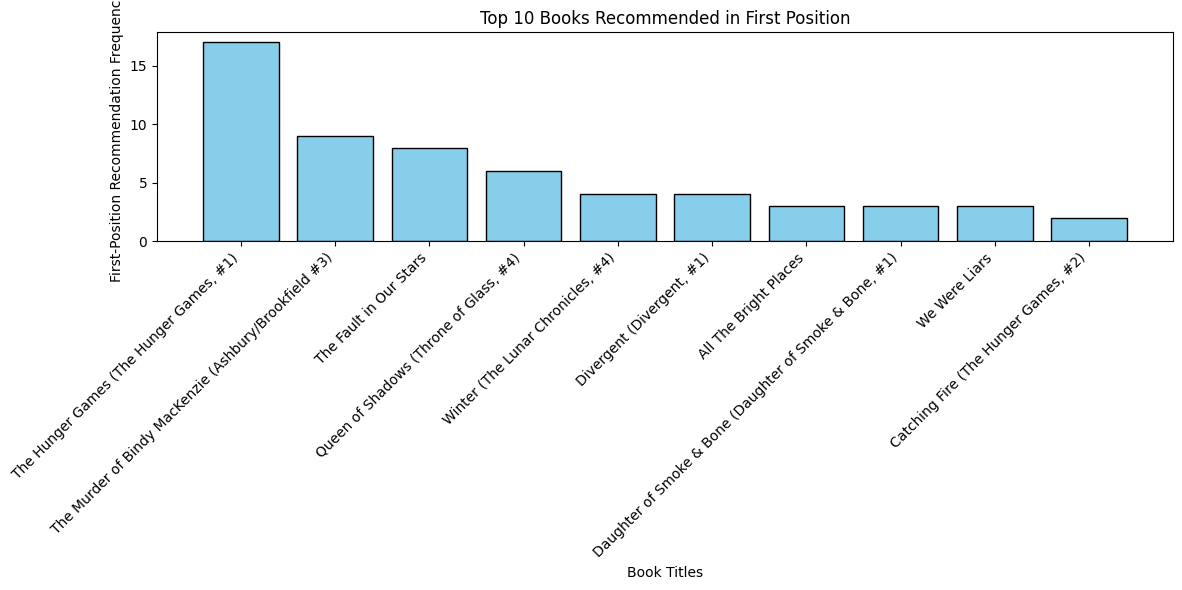

In [33]:
# Extract first-position recommendation directly in Polars
first_position_recs = test_res.select(
    pl.col("preds").list.get(0).alias("item_id")
)

# Count frequency
freq_df = (
    first_position_recs.group_by("item_id")
    .agg(pl.count().alias("count"))
    .sort("count", descending=True)
)

# Join with books metadata
top_10_df = (
    freq_df.head(10)
    .join(books.select(["item_id", "title"]), on="item_id", how="left")
    .with_columns(pl.col("title").fill_null("Unknown Title"))
)

# Prepare data for plotting
titles = top_10_df["title"].to_list()
counts = top_10_df["count"].to_list()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(titles, counts, color="skyblue", edgecolor="black")
plt.xlabel("Book Titles")
plt.ylabel("First-Position Recommendation Frequency")
plt.title("Top 10 Books Recommended in First Position")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
